# 2. System Matrices Evaluation and Control Input Derivation

In [1]:
import gym
import numpy as np
import tensorflow as tf
import pickle
import os
from os import path

## Import matrices for linear control systems

In [2]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)

2022-04-06 15:18:23.847550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np_weights = model.get_weights()
print(model.A.get_weights())
print(model.B.get_weights())

[array([[ 1.0000035e+00, -1.2942681e-05, -2.3801964e-05,  1.6305943e-03],
       [ 2.0008639e-02,  9.9992085e-01, -2.6311722e-05, -9.5092575e-04],
       [-8.2056704e-07, -1.3424688e-02,  1.0000260e+00,  3.1254122e-01],
       [-4.4493249e-06, -5.0352475e-05,  2.0024499e-02,  9.9951327e-01]],
      dtype=float32)]
[array([[ 6.6651064e-06,  1.9508155e-01, -1.1186228e-05, -2.9142728e-01]],
      dtype=float32)]


In [4]:
A = np_weights[0]
B = np_weights[1].T
print("A Matrix")
print(A)
print("B Matrix")
print(B)

A Matrix
[[ 1.0000035e+00 -1.2942681e-05 -2.3801964e-05  1.6305943e-03]
 [ 2.0008639e-02  9.9992085e-01 -2.6311722e-05 -9.5092575e-04]
 [-8.2056704e-07 -1.3424688e-02  1.0000260e+00  3.1254122e-01]
 [-4.4493249e-06 -5.0352475e-05  2.0024499e-02  9.9951327e-01]]
B Matrix
[[ 6.6651064e-06]
 [ 1.9508155e-01]
 [-1.1186228e-05]
 [-2.9142728e-01]]


## Deriving K

Rewrite the control system equation using $u = - Kx$.

$$
\begin{align}
    \dot x &= Ax - Bu \\
    \dot x &= Ax - BKx \\
\end{align}
$$

Define the target control system with the desired eigenvalue and eigenvector placements as $\dot x = Tx$.

Derive the state space to control input transformation $K$.

$$
\begin{align}
    \dot x 
        &= Tx \\
        &= Ax - BKx \\
    Tx &= Ax - BKx \\
    T &= A - BK \\
    K &= - B^{-1}_{left} (T - A) \\
\end{align}
$$

where $B^{-1}_{left}$ is the left inverse of $B$, which can be derived as,

$$
\begin{align}
    (A^T A)^{-1} A^T A &= I \\
    (A^T A)^{-1} A^T &= A^{-1}_{left} \\
\end{align}
$$

since $A^{-1}_{left} A = I$.

In [5]:
L, V = np.linalg.eig(A)
print("Eigenvalues")
print(L)
print("Eigenvectors")
print(V)

Eigenvalues
[1.0788951  1.0010113  0.9988714  0.92068577]
Eigenvectors
[[-0.0047632   0.05640477  0.05029647 -0.00535164]
 [ 0.00206137  0.99747103 -0.9978138   0.00398437]
 [-0.9696124   0.00572724 -0.0011242  -0.96919453]
 [-0.24459109  0.04286291 -0.04285515  0.24620616]]


In [6]:
# Define desirable T = A - BK (test)
T = np.diag((0, -1, -4, -2))

# calculate K
B_left_inv = np.matmul(np.linalg.inv(np.matmul(B.T, B)), B.T)
K = - np.matmul(B_left_inv, (T - A))
print("K Matrix")
print(K)

K Matrix
[[ 0.03180245  3.17239641 -0.04794625 -7.10913631]]


In [7]:
save_controller_dict = {"K": K, "Target": T, "A": A, "B": B}
print(save_controller_dict)
with open('./cartpole_system_model/controller.pkl', 'wb') as filepath:
    pickle.dump(save_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[ 0.03180245,  3.17239641, -0.04794625, -7.10913631]]), 'Target': array([[ 0,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -4,  0],
       [ 0,  0,  0, -2]]), 'A': array([[ 1.0000035e+00, -1.2942681e-05, -2.3801964e-05,  1.6305943e-03],
       [ 2.0008639e-02,  9.9992085e-01, -2.6311722e-05, -9.5092575e-04],
       [-8.2056704e-07, -1.3424688e-02,  1.0000260e+00,  3.1254122e-01],
       [-4.4493249e-06, -5.0352475e-05,  2.0024499e-02,  9.9951327e-01]],
      dtype=float32), 'B': array([[ 6.6651064e-06],
       [ 1.9508155e-01],
       [-1.1186228e-05],
       [-2.9142728e-01]], dtype=float32)}


## Testing

In [8]:
with open('./cartpole_system_model/controller.pkl', 'rb') as filepath:
    controller_dict = pickle.load(filepath)
K = controller_dict['K']

Plug in $u = -Kx$

In [9]:
env = gym.make('CartPole-v0')
x = env.reset()
cumul_reward = 0
for _ in range(1000):
    u = np.matmul(-K, x)
    if u < 0:
        u = 0
    else:
        u = 1
    x, reward, done, _ = env.step(u)
    cumul_reward += reward
    if done:
        break
env.close()
print(cumul_reward)

121.0


## Optimizing T

In [10]:
import cma

In [11]:
# A, B, and B_left_inv matrices are global
def cartpole_loss(target_matrix):
    # row-major target matrix to T
    selected_T = tf.reshape(target_matrix, [4, 4])
    
    # compute K given T
    selected_K = - np.matmul(B_left_inv, selected_T - A)
    
    # cartpole simulation
    env = gym.make('CartPole-v1')
    x = env.reset()
    cumul_reward = 500
    for _ in range(500):
        u = np.matmul(-selected_K, x)
        if u < 0:
            u = 0
        else:
            u = 1
        x, reward, done, _ = env.step(u)
        cumul_reward -= reward
        if done:
            break
    env.close()
    return cumul_reward

In [12]:
init_T = np.reshape(np.diag((0, -1, -4, -2)), [16, ])
es = cma.CMAEvolutionStrategy(init_T, 1.0)
with open('./cartpole_system_model/cma_es_history.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [cartpole_loss(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
with open('./cartpole_system_model/cma_es_history.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=331572, Wed Apr  6 15:18:25 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 5.000000000000000e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
    2     24 0.000000000000000e+00 1.1e+00 9.11e-01  9e-01  9e-01 0:00.1
    3     36 0.000000000000000e+00 1.2e+00 9.35e-01  9e-01  1e+00 0:00.2
   16    192 0.000000000000000e+00 1.8e+00 8.97e-01  8e-01  1e+00 0:01.3


termination on tolflatfitness=1
final/bestever f-value = 0.000000e+00 0.000000e+00
incumbent solution: [ 2.37992189  0.56374039 -3.47585936  0.88628805  0.19970891 -0.00735497
  2.7185344   3.28261219 ...]
std deviations: [0.84808557 0.94051928 0.88469366 0.86580675 0.80810827 0.875854
 0.9179952  0.96253578 ...]


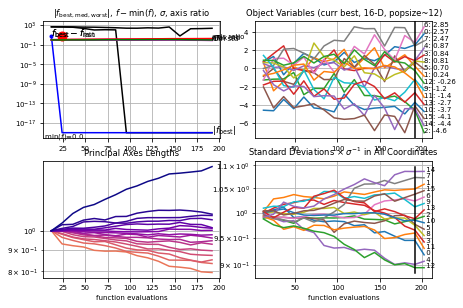

In [13]:
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()

In [14]:
with open('./cartpole_system_model/cma_es_history.pkl', 'rb') as filepath:
    es = pickle.load(filepath)
print(es)

In [15]:
dir(es)

['B',
 'C',
 'D',
 'N',
 'N_pheno',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_copy_light',
 '_flgtelldone',
 '_force_final_logging',
 '_injected_solutions_archive',
 '_prepare_callback_list',
 '_prepare_injection_directions',
 '_random_rescaling_factor_to_mahalanobis_size',
 '_record_rankings',
 '_record_rankings_',
 '_set_x0',
 '_stopdict',
 '_tfg',
 '_tfp',
 '_updateBDfromSM',
 'adapt_sigma',
 'alleviate_conditioning',
 'alleviate_conditioning_in_coordinates',
 'archive',
 'ary',
 'ask',
 'ask_and_eval',
 'ask_geno',
 'best',
 'boundary_handler',
 'callbackstop',
 'condition_number',
 'const',
 'count_eigen',
 'countevals',
 'countiter',
 'd

In [16]:
print(es.result.xbest)
print(es.result.fbest)

[ 1.30221468 -2.47239739 -1.1913795   1.62084544  0.10320403 -0.01669319
  1.07277205  0.32080505  0.58742325  0.11949963 -4.66529641 -0.55672433
  0.85978345 -1.43065735 -1.79578298 -4.35433958]
0.0


In [17]:
best_T = np.reshape(es.result.xbest, [4, 4])
best_K = - np.matmul(B_left_inv, best_T - A)

save_best_controller_dict = {"K": best_K, "Target": best_T, "A": A, "B": B}
print(save_best_controller_dict)
with open('./cartpole_system_model/best_controller.pkl', 'wb') as filepath:
    pickle.dump(save_best_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[  1.90541239,  -1.77724393,  -6.00483319, -13.19694214]]), 'Target': array([[ 1.30221468, -2.47239739, -1.1913795 ,  1.62084544],
       [ 0.10320403, -0.01669319,  1.07277205,  0.32080505],
       [ 0.58742325,  0.11949963, -4.66529641, -0.55672433],
       [ 0.85978345, -1.43065735, -1.79578298, -4.35433958]]), 'A': array([[ 1.0000035e+00, -1.2942681e-05, -2.3801964e-05,  1.6305943e-03],
       [ 2.0008639e-02,  9.9992085e-01, -2.6311722e-05, -9.5092575e-04],
       [-8.2056704e-07, -1.3424688e-02,  1.0000260e+00,  3.1254122e-01],
       [-4.4493249e-06, -5.0352475e-05,  2.0024499e-02,  9.9951327e-01]],
      dtype=float32), 'B': array([[ 6.6651064e-06],
       [ 1.9508155e-01],
       [-1.1186228e-05],
       [-2.9142728e-01]], dtype=float32)}
